<a href="https://colab.research.google.com/github/svnesh/MachineLearning/blob/master/used_car_price_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [0]:
root_path = "/content/drive/My Drive/User_car_price_prediction/Inputs"
df_train = pd.read_csv(os.path.join(root_path, "train-data.csv"))
df_test = pd.read_csv(os.path.join(root_path, "test-data.csv"))

In [0]:
df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

In [0]:
print("Skew %f", df_train['Price'].skew())
print("kurt %f", df_train['Price'].kurt())

Skew %f 3.3352319876668415
kurt %f 17.09220197043644


In [0]:
#A trial to check log of target label to avoid skew & kurt
df_test1 = np.log1p(df_train['Price'].values)

In [0]:
df_test1 = df_test1.reshape(-1,1)
df_test1 = pd.DataFrame(df_test1, columns=['PriceNew'])

In [0]:
print("Skew %f", df_test1['PriceNew'].skew())
print("kurt %f", df_test1['PriceNew'].kurt())

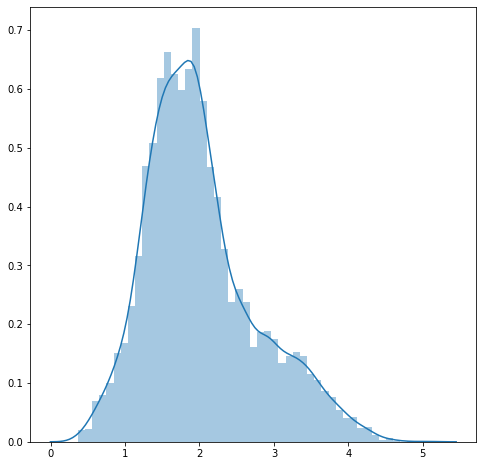

In [0]:
plt.figure(figsize=(8,8))
sns.distplot(df_test1.reshape(-1,1))
plt.set_title('After log')
plt.show()

In [0]:
df_train.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [0]:
df_test.sample(5)

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
929,929,Maruti Alto K10 VXI,Kochi,2016,39549,Petrol,Manual,First,24.07 kmpl,998 CC,67.1 bhp,5.0,4.09 Lakh
1186,1186,Mercedes-Benz E-Class E250 CDI Avantgrade,Coimbatore,2015,43020,Diesel,Automatic,First,13.0 kmpl,2143 CC,201.1 bhp,5.0,NaN
1197,1197,BMW X5 xDrive 30d Design Pure Experience 5 Seater,Delhi,2015,31000,Diesel,Automatic,Second,15.97 kmpl,2993 CC,258 bhp,5.0,NaN
339,339,Toyota Fortuner 2.8 2WD MT,Mumbai,2012,126000,Diesel,Manual,First,14.24 kmpl,2755 CC,174.5 bhp,7.0,35.16 Lakh
337,337,Hyundai i20 Magna,Mumbai,2009,85000,Petrol,Manual,First,18.5 kmpl,1197 CC,80 bhp,5.0,NaN


In [0]:
print(df_train.shape)
print(df_test.shape)

(6019, 14)
(1234, 13)


In [0]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1233 entries, 0 to 1233
Data columns (total 12 columns):
Location             1233 non-null object
Year                 1233 non-null int64
Kilometers_Driven    1233 non-null int64
Fuel_Type            1233 non-null object
Transmission         1233 non-null object
Owner_Type           1233 non-null object
Seats                1233 non-null float64
New_Price            182 non-null object
brand_name           1233 non-null object
Mileage_upd          1233 non-null float64
Engine_upd           1233 non-null float64
Power_upd            1233 non-null float64
dtypes: float64(4), int64(2), object(6)
memory usage: 125.2+ KB


In [0]:
df_train.describe()

,Unnamed: 0,Year,Kilometers_Driven,Seats,Price
count,6019.000000,6019.000000,6.019000e+03,5977.000000,6019.000000
mean,3009.000000,2013.358199,5.873838e+04,5.278735,9.479468
std,1737.679967,3.269742,9.126884e+04,0.808840,11.187917
min,0.000000,1998.000000,1.710000e+02,0.000000,0.440000
25%,1504.500000,2011.000000,3.400000e+04,5.000000,3.500000
50%,3009.000000,2014.000000,5.300000e+04,5.000000,5.640000
75%,4513.500000,2016.000000,7.300000e+04,5.000000,9.950000
max,6018.000000,2019.000000,6.500000e+06,10.000000,160.000000


1. Price column have outliers

In [0]:
miss_percent = (df_train.isnull().sum() / len(df_train)) * 100
missing = pd.DataFrame({"percent":miss_percent, 'count':df_train.isnull().sum()}).sort_values(by="percent", ascending=False)
missing.loc[missing['percent'] > 0]

,percent,count
New_Price,86.310018,5195
Seats,0.697790,42
Engine,0.598106,36
Power,0.598106,36
Mileage,0.033228,2


1. New_Price have more than 86% missing need to address, this column seems important to compare price between new car & used car price.
2. Mileage, Engine, Power, Seats have very few missing this can be addressed by filling mean, median or mode to avoid lossing data

In [0]:
miss_percent = (df_test.isnull().sum() / len(df_test)) * 100
missing = pd.DataFrame({"percent":miss_percent, 'count':df_test.isnull().sum()}).sort_values(by="percent", ascending=False)
missing.loc[missing['percent'] > 0]

,percent,count
New_Price,85.251216,1052
Seats,0.891410,11
Engine,0.810373,10
Power,0.810373,10


In [0]:
df_train.drop(df_train.columns[0], axis=1, inplace=True)
df_test.drop(df_test.columns[0], axis=1, inplace=True)

1. dropped the unnamed index column

In [0]:
df_train['brand_name'] = df_train['Name'].apply(lambda x: str(x).split(" ")[0])
df_test['brand_name'] = df_test['Name'].apply(lambda x: str(x).split(" ")[0])

1. created a new column as 'brand_name'

In [0]:
df_train.drop(columns=["Name"], axis=1, inplace=True)
df_test.drop(columns=["Name"], axis=1, inplace=True)

1. Dropped the 'Name' column from both train & test data

In [0]:
#df_train.loc[df_train['brand_name'] == 'Maruti']['Seats'].mode()[0]
def fill_na_with_mode(ds, brandname):
  fill_value = ds.loc[ds['brand_name'] == brandname]['Seats'].mode()[0]
  condit = ((ds['brand_name'] == brandname) & (ds['Seats'].isnull()))
  ds.loc[condit, 'Seats'] = ds.loc[condit, 'Seats'].fillna(fill_value)

In [0]:
car_brand = ['Maruti','Hyundai','BMW','Fiat','Land','Ford','Toyota','Honda','Skoda','Mahindra']
for c in car_brand:
  fill_na_with_mode(df_train, c)
  fill_na_with_mode(df_test, c)

1. Replaced all missing values in seats with mode of the specified brand name

In [0]:
df_test.loc[df_test['Seats'].isnull()]

In [0]:
import re

df_train['Mileage_upd'] = df_train['Mileage'].apply(lambda x: re.sub(r'(\d+\.\d+)\s(kmpl|km\/kg)', r'\1', str(x)))
df_train['Engine_upd'] = df_train['Engine'].apply(lambda x: re.sub(r'(\d+)\s(CC)', r'\1', str(x)))
df_train['Power_upd'] = df_train['Power'].apply(lambda x: re.sub(r'(\d+\.?\d+?)\s(bhp)', r'\1', str(x)))

df_test['Mileage_upd'] = df_test['Mileage'].apply(lambda x: re.sub(r'(\d+\.\d+)\s(kmpl|km\/kg)', r'\1', str(x)))
df_test['Engine_upd'] = df_test['Engine'].apply(lambda x: re.sub(r'(\d+)\s(CC)', r'\1', str(x)))
df_test['Power_upd'] = df_test['Power'].apply(lambda x: re.sub(r'(\d+\.?\d+?)\s(bhp)', r'\1', str(x)))

1. Removed the km/kg & km/l from mileage to make as numeric column
2. removed the 'CC' and 'bhp' from engine & power columns to change as numeric

In [0]:
df_train['Mileage_upd'] = pd.to_numeric(df_train['Mileage_upd'], errors='coerce')
df_train['Engine_upd'] = pd.to_numeric(df_train['Engine_upd'], errors='coerce')
df_train['Power_upd'] = pd.to_numeric(df_train['Power_upd'], errors='coerce')

df_test['Mileage_upd'] = pd.to_numeric(df_test['Mileage_upd'], errors='coerce')
df_test['Engine_upd'] = pd.to_numeric(df_test['Engine_upd'], errors='coerce')
df_test['Power_upd'] = pd.to_numeric(df_test['Power_upd'], errors='coerce')

1. converted the 3 columns to float

In [0]:
df_train.drop(columns=['Mileage', 'Engine', 'Power'], inplace=True)
df_test.drop(columns=['Mileage', 'Engine', 'Power'], inplace=True)

1. Removed the mileage,engine,power columns with updated columns

In [0]:
df_train.drop(df_train[df_train['brand_name'] == 'Smart'].index, axis=0, inplace=True)
df_test.drop(df_test[df_test['brand_name'] == 'Hindustan'].index, axis=0, inplace=True)

1. Removed 1 row with unique brand having null value for Power.

In [0]:
#Function to replace na value with mode of that specific brand
def fill_na_with_mode(ds, brandname, colname):
  fill_value = ds.loc[ds['brand_name'] == brandname][colname].mode()[0]
  condit = ((ds['brand_name'] == brandname) & (ds[colname].isnull()))
  ds.loc[condit, colname] = ds.loc[condit, colname].fillna(fill_value)

In [0]:
miss_Mileage_col = df_train.loc[df_train['Mileage_upd'].isnull()]['brand_name'].unique()
miss_Engine_col = df_train.loc[df_train['Engine_upd'].isnull()]['brand_name'].unique()
miss_Power_col = df_train.loc[df_train['Power_upd'].isnull()]['brand_name'].unique()

for x in miss_Mileage_col:
  fill_na_with_mode(df_train, x, 'Mileage_upd')
for y in miss_Engine_col:
  fill_na_with_mode(df_train, y, 'Engine_upd')
for z in miss_Power_col:
  fill_na_with_mode(df_train, z, 'Power_upd')

In [0]:
miss_ts_Mileage_col = df_test.loc[df_test['Mileage_upd'].isnull()]['brand_name'].unique()
miss_ts_Engine_col = df_test.loc[df_test['Engine_upd'].isnull()]['brand_name'].unique()
miss_ts_Power_col = df_test.loc[df_test['Power_upd'].isnull()]['brand_name'].unique()

for x in miss_ts_Mileage_col:
  fill_na_with_mode(df_test, x, 'Mileage_upd')
for y in miss_ts_Engine_col:
  fill_na_with_mode(df_test, y, 'Engine_upd')
for z in miss_ts_Power_col:
  fill_na_with_mode(df_test, z, 'Power_upd')

In [0]:
zero_mileage_col = df_train.loc[df_train['Mileage_upd'] == 0.0]['brand_name'].unique()

for m in zero_mileage_col:
  fill_zero = df_train.loc[df_train['brand_name'] == m]['Mileage_upd'].mode()[0]
  m1 = ((df_train['brand_name'] == m) & (df_train['Mileage_upd'] == 0.0))
  df_train.loc[m1, 'Mileage_upd'] = fill_zero

In [0]:
zero_mileage_col2 = df_test.loc[df_test['Mileage_upd'] == 0.0]['brand_name'].unique()

for m in zero_mileage_col2:
  fill_zero = df_test.loc[df_test['brand_name'] == m]['Mileage_upd'].mode()[0]
  m1 = ((df_test['brand_name'] == m) & (df_test['Mileage_upd'] == 0.0))
  df_test.loc[m1, 'Mileage_upd'] = fill_zero

1. Replaced 0.0 values with mode for column Mileage_upd

In [0]:
for col in df_test.columns:
  print(col)
  print(len(df_test.loc[df_test[col] == 0.0]))

In [0]:
m1 = (df_train['Seats'] == 0.0)
df_train.loc[m1, 'Seats'] = 5.0

1. Replaced 1 zero value of seats with 5.0

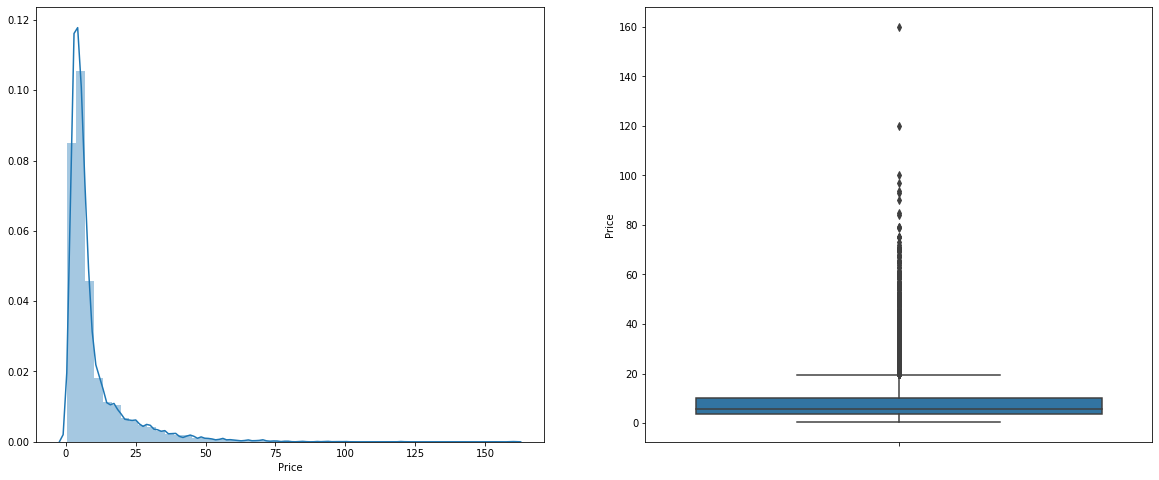

In [0]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.distplot(df_train['Price'])

plt.subplot(1,2,2)
sns.boxplot(y=df_train['Price'])
plt.show()

1. Price column squweed in right, so label is not properly distributed

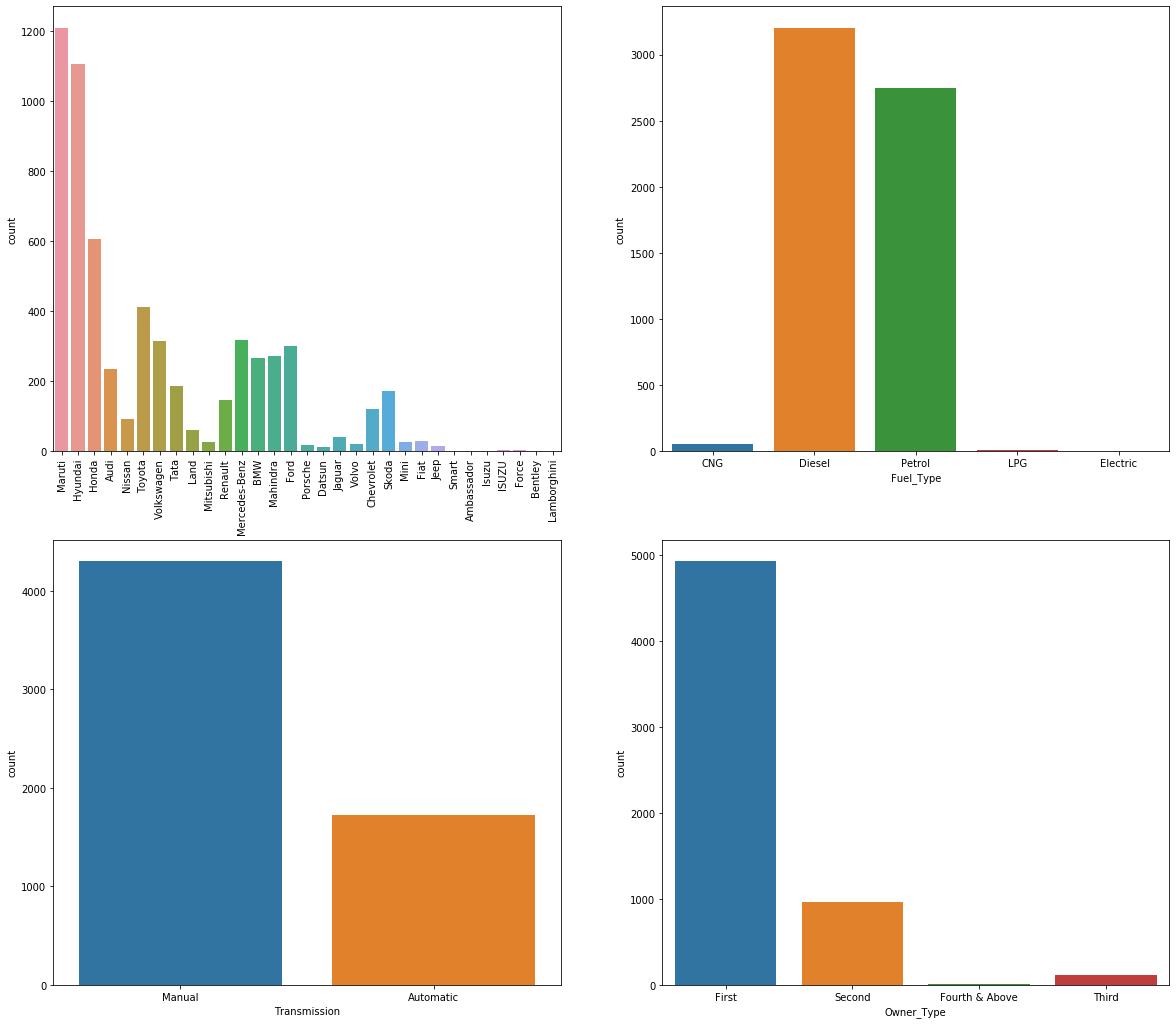

In [0]:
fig = plt.figure(figsize=(20,18))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
fig.add_subplot(2,2,1)
g1 = sns.countplot(x='brand_name', data=df_train)
loc,labels = plt.xticks()
g1.set_xticklabels(labels,rotation=90)
fig.add_subplot(2,2,2)
g2 = sns.countplot(x='Fuel_Type', data=df_train)
loc,labels = plt.xticks()
g2.set_xticklabels(labels,rotation=0)
fig.add_subplot(2,2,3)
g3 = sns.countplot(x='Transmission', data=df_train)
loc,labels = plt.xticks()
g3.set_xticklabels(labels,rotation=0)
fig.add_subplot(2,2,4)
g4 = sns.countplot(x='Owner_Type', data=df_train)
loc,labels = plt.xticks()
g4.set_xticklabels(labels,rotation=0)
plt.show()

1. Maruti is leading car brand, fueltype both diesel & petrol are almost equal
2. Manual gear transmission is high, First owernership is high, also have second

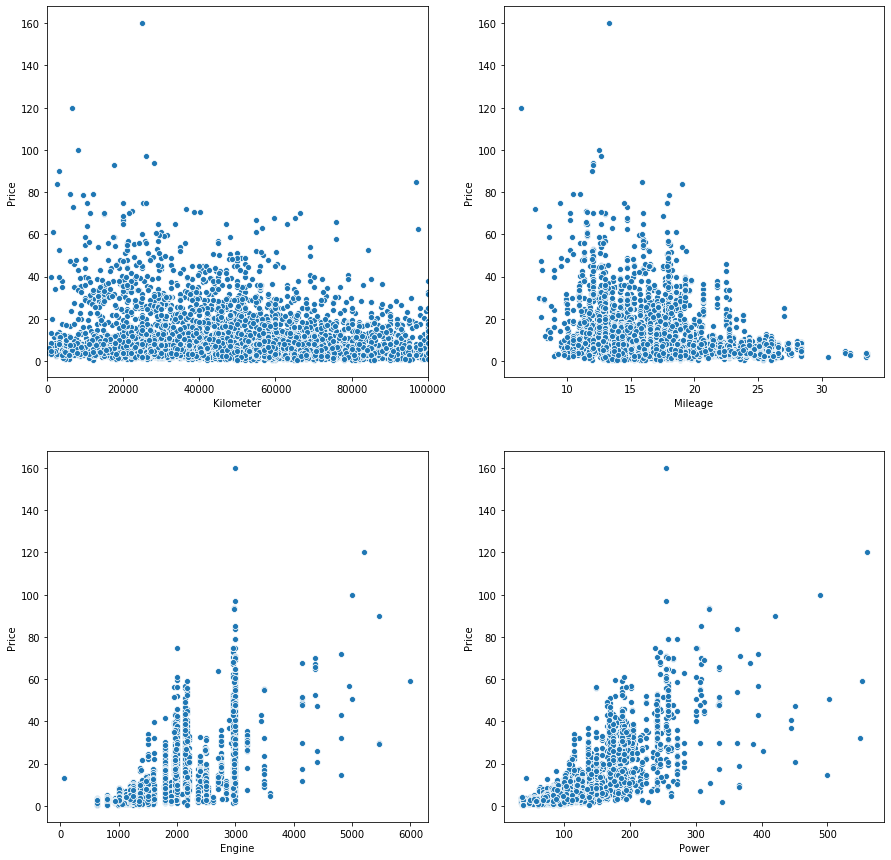

In [0]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(2,2,1)
plt.xlim([0, 100000])
p1 = sns.scatterplot(x="Kilometers_Driven", y="Price", data=df_train)
loc, labels = plt.xticks()
ax1.set_xlabel('Kilometer')

ax2 = fig.add_subplot(2,2,2)
#plt.xlim([0, 100000])
p2 = sns.scatterplot(x="Mileage_upd", y="Price", data=df_train)
loc, labels = plt.xticks()
ax2.set_xlabel('Mileage')

ax3 = fig.add_subplot(2,2,3)
#plt.xlim([0, 100000])
p3 = sns.scatterplot(x="Engine_upd", y="Price", data=df_train)
loc, labels = plt.xticks()
ax3.set_xlabel('Engine')

ax4 = fig.add_subplot(2,2,4)
#plt.xlim([0, 100000])
p4 = sns.scatterplot(x="Power_upd", y="Price", data=df_train)
loc, labels = plt.xticks()
ax4.set_xlabel('Power')

plt.show()

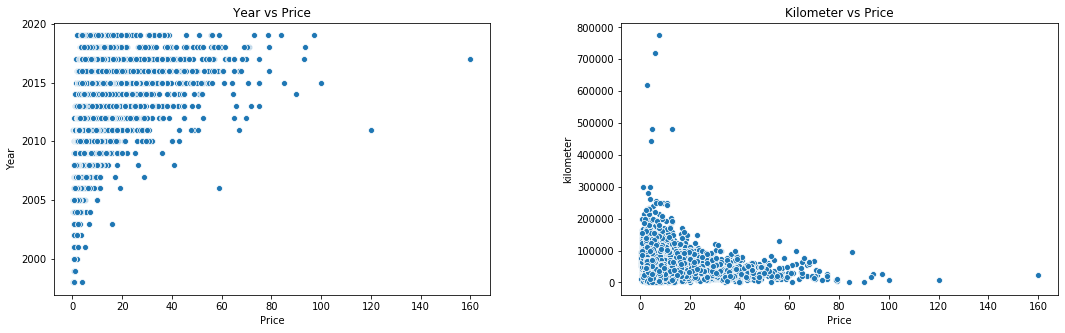

In [0]:
fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(1,2,1)
sns.scatterplot(x='Price', y="Year", data=df_train)
ax1.set_xlabel('Price')
ax1.set_ylabel('Year')
ax1.set_title('Year vs Price')

ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x='Price', y='Kilometers_Driven', data=df_train)
ax2.set_ylabel('kilometer')
ax2.set_xlabel('Price')
ax2.set_title('Kilometer vs Price')
plt.show()

In [0]:
df_train.drop(df_train[df_train['Kilometers_Driven'] >= 6500000].index, axis=0, inplace=True)

1. deleted a outlier row from training data.

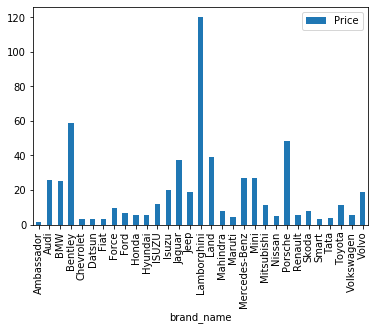

In [0]:
df_vis_1 = pd.DataFrame(df_train.groupby('brand_name')['Price'].mean())
df_vis_1.plot.bar()
plt.show()

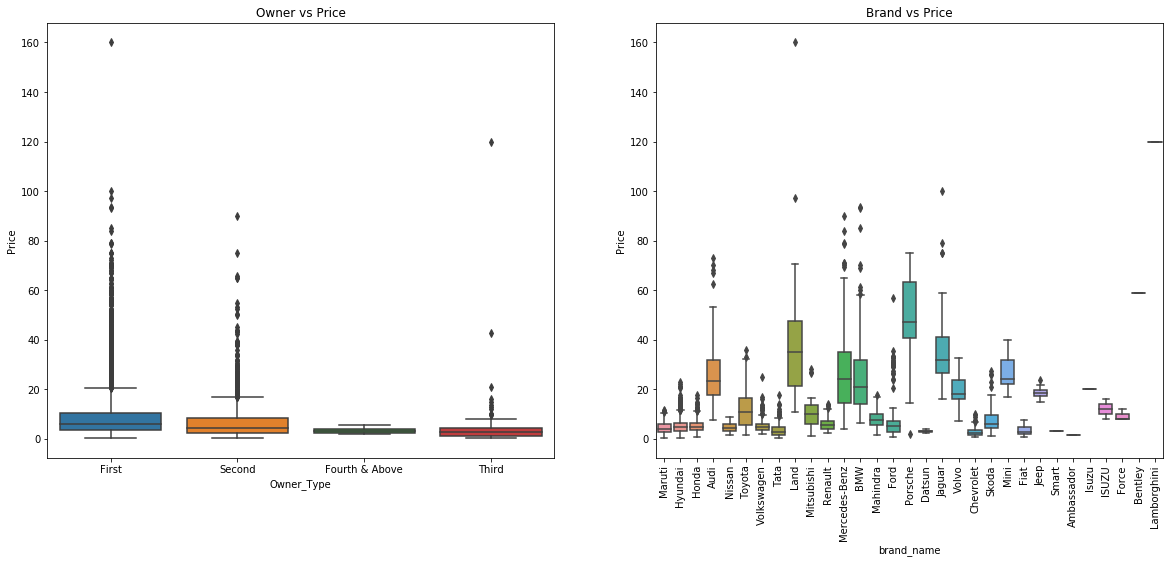

In [0]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,2,1)
sns.boxplot(x='Owner_Type', y='Price', data=df_train)
ax1.set_title('Owner vs Price')

ax2 = fig.add_subplot(1,2,2)
sns.boxplot(x='brand_name', y='Price', data=df_train)
loc,labels = plt.xticks()
ax2.set_xticklabels(labels, rotation=90)
ax2.set_title('Brand vs Price')
plt.show()

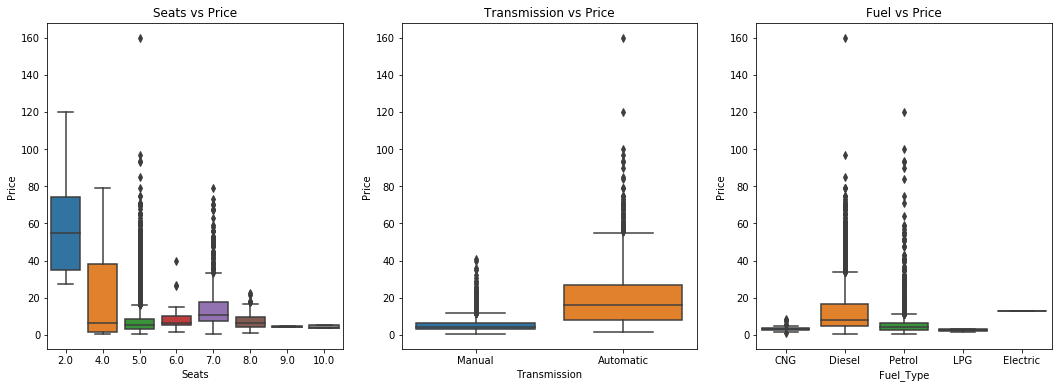

In [0]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,3,1)
sns.boxplot(x='Seats', y='Price', data=df_train)
ax1.set_title('Seats vs Price')

ax2 = fig.add_subplot(1,3,2)
sns.boxplot(x='Transmission', y='Price', data=df_train)
ax2.set_title('Transmission vs Price')

ax3 = fig.add_subplot(1,3,3)
sns.boxplot(x='Fuel_Type', y='Price', data=df_train)
ax3.set_title('Fuel vs Price')

plt.show()

In [0]:
import datetime
now = datetime.datetime.now()
df_train['Year_upd'] = df_train['Year'].apply(lambda x : now.year - x)
df_test['Year_upd'] = df_test['Year'].apply(lambda x : now.year - x)

1. Added new column by getting the year count when it is bought

In [0]:
df_train.drop(columns=['Year'], axis=1, inplace=True)
df_test.drop(columns=['Year'], axis=1, inplace=True)

1. dropped the 'year' column

In [0]:
df_train.drop(columns=['New_Price'], axis=1, inplace=True)
df_test.drop(columns=['New_Price'], axis=1, inplace=True)

1. 'Newprice' column deleted having most null values, but need to input the price details in future to get better prediction [to do]

In [0]:
df_train.drop(columns=['Location'], axis=1, inplace=True)
df_test.drop(columns=['Location'], axis=1, inplace=True)

1. 'Location' column not needed for price prediction.

In [0]:
df_train_norm = pd.get_dummies(df_train, drop_first=True)
df_test_norm = pd.get_dummies(df_test, drop_first=True)

1. Changed categorical variables to numerical data the both training and test set

In [0]:
df_train_norm['Price_upd'] = np.log1p(df_train_norm['Price'].values)

1. add new column after taking logarithm for the dependent variable to avoid high skewness & kurtosis

In [0]:
df_train_norm.drop(columns=['Price'], axis=1, inplace=True)

In [0]:
df_train_X = df_train_norm.drop(columns=['Price_upd'], axis=1)
df_train_y = df_train_norm[['Price_upd']]

1. Seperated X & y values

In [0]:
df_train_X = (df_train_X - df_train_X.mean())/df_train_X.std()
df_test_norm = (df_test_norm - df_test_norm.mean())/df_test_norm.std()

1. Normalized the train and test data

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(df_train_X, df_train_y, test_size=0.22, random_state=1)
reg = lm.fit(X_train, y_train)

1. splitted train test split because test set dont have labels to verify accuracy

In [0]:
y_predict = reg.predict(X_test)
y_predict

array([[2.05524676],
       [1.87894724],
       [2.04183687],
       ...,
       [0.74960554],
       [1.52632019],
       [2.0856545 ]])

In [0]:
from sklearn.metrics import r2_score

r2_score(y_predict, y_test)

0.8930366000132931

In [0]:
reg.score(X_test,y_test)

0.7744560165848509

1. final r2 score, well done